# Chapter 8 — Data Preparation & Quality

In [1]:
# ── Colab auto-setup (safe to run locally too) ───────────────────
import sys, os

if "google.colab" in sys.modules:
    if not os.path.exists("/content/vietnamese-tts-course"):
        !git clone https://github.com/thinhdanggroup/vietnamese-tts-course.git /content/vietnamese-tts-course
    os.chdir("/content/vietnamese-tts-course/chapters")
    !pip install -q librosa soundfile matplotlib

    if not os.path.exists("/content/VieNeu-TTS"):
        !git clone https://github.com/pnnbao97/VieNeu-TTS.git /content/VieNeu-TTS
        !pip install -q -e /content/VieNeu-TTS
    sys.path.insert(0, "/content/VieNeu-TTS")
    print("Colab setup complete.")

Colab setup complete.


In [2]:
import os, librosa, soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

# ── Path resolver (works regardless of Jupyter CWD) ──────────────
from pathlib import Path
import os as _os

def _find_examples_dir():
    # Walk up from CWD (works locally when kernel starts in chapters/)
    for _p in [Path(_os.getcwd())] + list(Path(_os.getcwd()).parents):
        _d = _p / "examples" / "audio_ref"
        if _d.is_dir():
            return _d
    # Colab fallback paths
    for _candidate in [
        Path("/content/vietnamese-tts-course/examples/audio_ref"),
        Path("/content/VieNeu-TTS/examples/audio_ref"),
    ]:
        if _candidate.is_dir():
            return _candidate
    raise FileNotFoundError(
        "examples/audio_ref/ not found. "
        "Clone the repo: git clone https://github.com/thinhdanggroup/vietnamese-tts-course.git"
    )

EXAMPLES_DIR = _find_examples_dir()
print(f"Examples dir: {EXAMPLES_DIR}")

Examples dir: /content/VieNeu-TTS/examples/audio_ref


## 1. Load and Analyze the Example Dataset

In [3]:
audio_dir = str(EXAMPLES_DIR)
files = sorted([f for f in os.listdir(audio_dir) if f.endswith(".wav")])

stats = []
for f in files:
    path = os.path.join(audio_dir, f)
    info = sf.info(path)
    wav, sr = librosa.load(path, sr=None)
    rms_db = 20 * np.log10(np.sqrt(np.mean(wav**2)) + 1e-9)
    intervals = librosa.effects.split(wav, top_db=25)
    speech_samples = sum(e - s for s, e in intervals)
    stats.append({
        "file": f,
        "duration_s": round(info.duration, 2),
        "sample_rate": info.samplerate,
        "rms_db": round(rms_db, 1),
        "speech_ratio": round(speech_samples / len(wav), 2)
    })

df = pd.DataFrame(stats)
print(df.to_string())
print(f"\nMean duration: {df['duration_s'].mean():.2f}s")
print(f"All within 3-15s: {((df['duration_s'] >= 3) & (df['duration_s'] <= 15)).all()}")

                     file  duration_s  sample_rate     rms_db  speech_ratio
0             example.wav        2.47        24000 -23.700001          0.80
1           example_2.wav        3.62        24000 -17.200001          0.66
2           example_3.wav        1.19        24000 -23.600000          0.77
3           example_4.wav        4.01        24000 -16.299999          0.92
4  example_ngoc_huyen.wav        4.52        24000 -17.200001          0.75

Mean duration: 3.16s
All within 3-15s: False


## 2. SNR Estimation

In [4]:
def estimate_snr(wav, top_db=30):
    intervals = librosa.effects.split(wav, top_db=top_db)
    if len(intervals) == 0:
        return 0.0
    speech = np.concatenate([wav[s:e] for s, e in intervals])
    speech_power = np.mean(speech**2)
    mask = np.zeros(len(wav), dtype=bool)
    for s, e in intervals:
        mask[s:e] = True
    silence = wav[~mask]
    if len(silence) < 100:
        return 60.0
    noise_power = np.mean(silence**2)
    if noise_power < 1e-10:
        return 60.0
    return 10 * np.log10(speech_power / (noise_power + 1e-10))

for f in files:
    path = os.path.join(audio_dir, f)
    wav, sr = librosa.load(path, sr=None)
    snr = estimate_snr(wav)
    status = "Good (>25dB)" if snr > 25 else "Check"
    print(f"{f}: SNR = {snr:.1f} dB  [{status}]")

example.wav: SNR = 31.3 dB  [Good (>25dB)]
example_2.wav: SNR = 38.3 dB  [Good (>25dB)]
example_3.wav: SNR = 38.3 dB  [Good (>25dB)]
example_4.wav: SNR = 44.9 dB  [Good (>25dB)]
example_ngoc_huyen.wav: SNR = 65.5 dB  [Good (>25dB)]


## 3. Vietnamese Tone Distribution

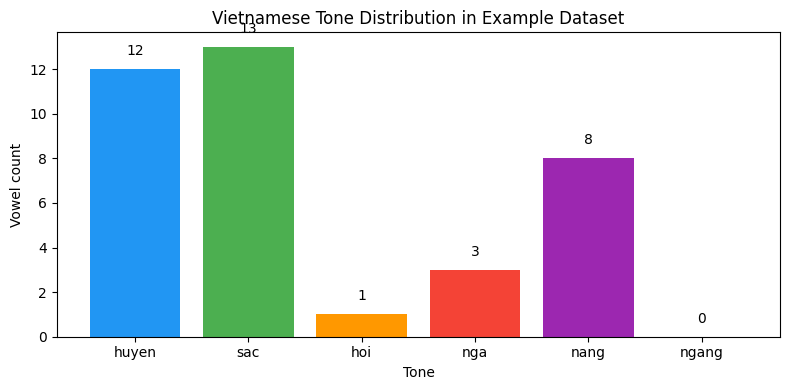

In [5]:
txt_files = sorted([f for f in os.listdir(audio_dir) if f.endswith(".txt")])
all_text = ""
for f in txt_files:
    with open(os.path.join(audio_dir, f), encoding="utf-8") as fh:
        all_text += fh.read() + " "

tone_patterns = {
    "huyen": r"[\u00e0\u1eb1\u1ea7\u1ea9\u1eab\u1ead\u00e8\u1ec1\u1ec3\u1ec5\u1ec7\u00ec\u1ec9\u1ecb\u00f2\u1ed3\u1ed5\u1ed7\u1ed9\u00f9\u1eeb\u1eed\u1eef\u1ef1\u1ef3\u1ef7\u1ef9\u1ef5]",
    "sac":   r"[\u00e1\u1eaf\u1ea5\u00e9\u1ebf\u00ed\u00f3\u1ed1\u00fa\u1ee9\u00fd]",
    "hoi":   r"[\u1ea3\u1eb3\u1ea9\u1ebb\u1ec3\u1ec9\u1ecf\u1ed5\u1ee7\u1eed\u1ef7]",
    "nga":   r"[\u00e3\u1eb5\u1eab\u1ebd\u1ec5\u0129\u00f5\u1ed7\u0169\u1ef1\u1ef9]",
    "nang":  r"[\u1ea1\u1eb7\u1ead\u1eb9\u1ec7\u1ecb\u1ecd\u1ed9\u1ee5\u1ef1\u1ef5]",
}
counts = {}
for tone, pat in tone_patterns.items():
    counts[tone] = len(re.findall(pat, all_text))
total = len(re.findall(r"[aă\u00e2e\u00eaioô\u01a1u\u01b0y]", all_text, re.IGNORECASE))
counts["ngang"] = max(0, total - sum(counts.values()))

plt.figure(figsize=(8, 4))
colors = ["#2196F3","#4CAF50","#FF9800","#F44336","#9C27B0","#795548"]
bars = plt.bar(list(counts.keys()), list(counts.values()), color=colors)
plt.title("Vietnamese Tone Distribution in Example Dataset")
plt.ylabel("Vowel count")
plt.xlabel("Tone")
for bar, count in zip(bars, counts.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             str(count), ha="center", va="bottom")
plt.tight_layout()
plt.show()

## 4. Filter Pipeline — What Gets Removed and Why

In [6]:
import re

def text_filter(text):
    """Mirrors finetune/data_scripts/filter_data.py logic"""
    if not text:
        return False, "empty text"
    if re.search(r"\d", text):
        return False, "contains digits"
    if re.compile(r"(?:[a-zA-Z]\.){2,}").search(text):
        return False, "contains acronym (with dots)"
    if re.compile(r"(?:[A-Z]){2,}").search(text):
        return False, "contains acronym (uppercase)"
    if text.strip()[-1] not in ".,?!":
        return False, "missing end punctuation"
    return True, "OK"

test_cases = [
    "Xin ch\u00e0o Vi\u1ec7t Nam.",
    "N\u0103m 2024 l\u00e0 n\u0103m quan tr\u1ecdng.",
    "AI \u0111ang ph\u00e1t tri\u1ec3n m\u1ea1nh.",
    "H\u1ec7 th\u1ed1ng TTS ho\u1ea1t \u0111\u1ed9ng t\u1ed1t.",
    "T\u00f4i th\u00edch h\u1ecdc machine learning",
    "H\u00f4m nay tr\u1eddi \u0111\u1eb9p l\u1eafm.",
]

for text in test_cases:
    passed, reason = text_filter(text)
    icon = "PASS" if passed else "FAIL"
    print(f"[{icon}] {text!r:45s}  reason: {reason}")

[PASS] 'Xin chào Việt Nam.'                           reason: OK
[FAIL] 'Năm 2024 là năm quan trọng.'                  reason: contains digits
[FAIL] 'AI đang phát triển mạnh.'                     reason: contains acronym (uppercase)
[FAIL] 'Hệ thống TTS hoạt động tốt.'                  reason: contains acronym (uppercase)
[FAIL] 'Tôi thích học machine learning'               reason: missing end punctuation
[PASS] 'Hôm nay trời đẹp lắm.'                        reason: OK


## 5. Audio Preprocessing Pipeline

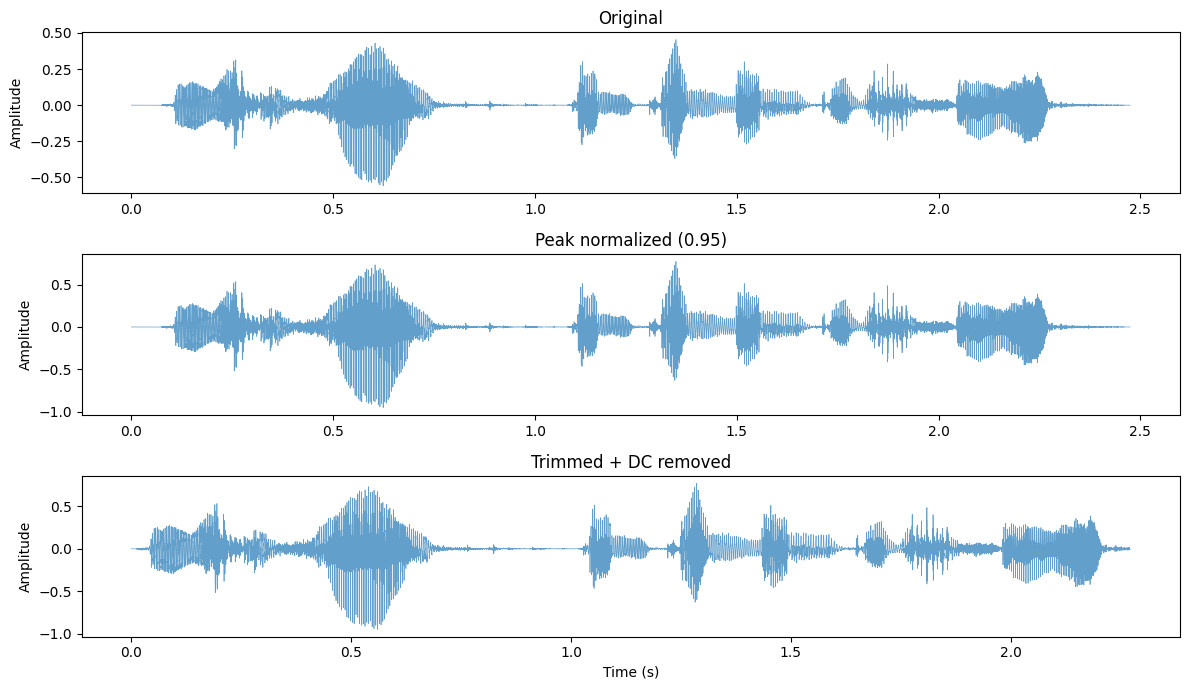

Original:     2.475s
After trim:   2.272s
Removed:      0.203s of silence


In [7]:
from IPython.display import Audio, display

wav, sr = librosa.load(str(EXAMPLES_DIR / "example.wav"), sr=16000)

# Step 1: Peak normalization
wav_norm = wav / (np.max(np.abs(wav)) + 1e-8) * 0.95

# Step 2: Silence trimming
wav_trimmed, _ = librosa.effects.trim(wav_norm, top_db=25)

# Step 3: DC offset removal
wav_clean = wav_trimmed - np.mean(wav_trimmed)

fig, axes = plt.subplots(3, 1, figsize=(12, 7))
for ax, w, title in zip(axes,
    [wav, wav_norm, wav_clean],
    ["Original", "Peak normalized (0.95)", "Trimmed + DC removed"]):
    t = np.linspace(0, len(w)/16000, len(w))
    ax.plot(t, w, alpha=0.7, linewidth=0.5)
    ax.set_title(title)
    ax.set_ylabel("Amplitude")
axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

print(f"Original:     {len(wav)/16000:.3f}s")
print(f"After trim:   {len(wav_clean)/16000:.3f}s")
print(f"Removed:      {(len(wav)-len(wav_clean))/16000:.3f}s of silence")

## 6. Dataset Quality Checklist

Before running the training pipeline, verify:

| Check | Requirement | Why |
|-------|-------------|-----|
| Duration | 3–15 s per clip | Filter requirement |
| Sample rate | ≥ 16 kHz | Codec encode requirement |
| SNR | > 25 dB | Clean training signal |
| Tone coverage | All 6 tones present | Avoid tone bias |
| No digits | Text only | Ambiguous pronunciation |
| No acronyms | Written out | Ambiguous pronunciation |
| Punctuation | Ends with `.`, `,`, `?`, `!` | Filter requirement |
| Single speaker | Yes | Voice consistency |